# Regression Models and Complementary Datasets (Continued)
**Project**: M4 Project 4
**Author**: Jacob Buysse

In this project we will be performing regression modeling on home sale pricing and them combining that dataset with a complimentary dataset to see how it might improve the model performance.

In this notebook we will be using...

In [22]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

We will configure our plots for readable labels, high resolution, and automatic layout.

In [23]:
plt.rc("axes", labelsize=18)
plt.rc("figure", dpi=150, autolayout=True)

## Part III

Now we will load and clean some complimentary data.  We will load data regarding population, public schools, and tax returns and organize that data by zip code to join to our original dataset.

### Population By Zip from 2010

Let us load the population dataset and view the head/info/describe properties.

In [2]:
pop_df = pd.read_csv("./population_by_zip_2010.csv")
pop_df.head()

,population,minimum_age,maximum_age,gender,zipcode,geo_id
0,50,30.0,34.0,female,61747,8600000US61747
1,5,85.0,NaN,male,64120,8600000US64120
2,1389,30.0,34.0,male,95117,8600000US95117
3,231,60.0,61.0,female,74074,8600000US74074
4,56,0.0,4.0,female,58042,8600000US58042


In [3]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622831 entries, 0 to 1622830
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   population   1622831 non-null  int64  
 1   minimum_age  1523474 non-null  float64
 2   maximum_age  1457236 non-null  float64
 3   gender       1589712 non-null  object 
 4   zipcode      1622831 non-null  int64  
 5   geo_id       1622831 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 74.3+ MB


In [4]:
pop_df.describe()

,population,minimum_age,maximum_age,zipcode
count,1.622831e+06,1.523474e+06,1.457236e+06,1.622831e+06
mean,5.775914e+02,4.152174e+01,4.240909e+01,4.966782e+04
std,2.891038e+03,2.515495e+01,2.407500e+01,2.756362e+04
min,0.000000e+00,0.000000e+00,4.000000e+00,6.020000e+02
25%,1.300000e+01,2.000000e+01,2.000000e+01,2.663600e+04
50%,6.000000e+01,4.000000e+01,4.150000e+01,4.974000e+04
75%,2.770000e+02,6.500000e+01,6.400000e+01,7.212500e+04
max,1.139160e+05,8.500000e+01,8.400000e+01,9.992900e+04


At first glance, we have 1.6M rows with a min/max age by gender by zip code.  Let us verify the multiple genders by zip code.

In [5]:
pop_df[pop_df.zipcode == 95117].head(25)

,population,minimum_age,maximum_age,gender,zipcode,geo_id
2,1389,30.0,34.0,male,95117,8600000US95117
19849,724,22.0,24.0,female,95117,8600000US95117
32770,209,20.0,20.0,male,95117,8600000US95117
73791,246,70.0,74.0,male,95117,8600000US95117
105096,842,10.0,14.0,male,95117,8600000US95117
135085,164,65.0,66.0,female,95117,8600000US95117
145757,958,50.0,54.0,male,95117,8600000US95117
155113,452,15.0,17.0,female,95117,8600000US95117
190651,173,67.0,69.0,male,95117,8600000US95117
227707,204,21.0,21.0,male,95117,8600000US95117


Ah, not exactly what I expected.  It now appears the data is split into multiple age ranges by gender by zip with a lower bound age of zero and an upper bound age of `NaN`.  Let us see if there is a pattern of age ranges across the dataset.

In [6]:
pop_df.minimum_age.value_counts()

minimum_age
30.0    66238
67.0    66238
55.0    66238
20.0    66238
65.0    66238
50.0    66238
62.0    66238
35.0    66238
45.0    66238
40.0    66238
18.0    66238
21.0    66238
85.0    66238
5.0     66238
25.0    66238
10.0    66238
70.0    66238
15.0    66238
80.0    66238
22.0    66238
0.0     66238
60.0    66238
75.0    66238
Name: count, dtype: int64

In [7]:
pop_df.maximum_age.value_counts()

maximum_age
34.0    66238
61.0    66238
59.0    66238
20.0    66238
66.0    66238
54.0    66238
64.0    66238
39.0    66238
49.0    66238
44.0    66238
19.0    66238
69.0    66238
21.0    66238
9.0     66238
29.0    66238
14.0    66238
74.0    66238
17.0    66238
84.0    66238
24.0    66238
4.0     66238
79.0    66238
Name: count, dtype: int64

Okay, so let us create a bucket (gender/min/max) and pivot the results.

In [8]:
pop_df["bucket"] = (
    "pop_" + pop_df.gender.fillna("unspecified") +
    "_" + pop_df.minimum_age.apply(lambda value: "" if pd.isna(value) else f"{value:.0f}") +
    "_" + pop_df.maximum_age.apply(lambda value: "" if pd.isna(value) else f"{value:.0f}")
)
pop_df.bucket.value_counts()
zip_pop_df = pop_df.pivot_table("population", ["zipcode"], "bucket")
zip_pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33119 entries, 602 to 99929
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pop_female_0_4     33119 non-null  float64
 1   pop_female_10_14   33119 non-null  float64
 2   pop_female_15_17   33119 non-null  float64
 3   pop_female_18_19   33119 non-null  float64
 4   pop_female_20_20   33119 non-null  float64
 5   pop_female_21_21   33119 non-null  float64
 6   pop_female_22_24   33119 non-null  float64
 7   pop_female_25_29   33119 non-null  float64
 8   pop_female_30_34   33119 non-null  float64
 9   pop_female_35_39   33119 non-null  float64
 10  pop_female_40_44   33119 non-null  float64
 11  pop_female_45_49   33119 non-null  float64
 12  pop_female_50_54   33119 non-null  float64
 13  pop_female_55_59   33119 non-null  float64
 14  pop_female_5_9     33119 non-null  float64
 15  pop_female_60_61   33119 non-null  float64
 16  pop_female_62_64   33119 

And now we have 33,119 zip codes with 49 columns of population groupings.

### Public Schools

Let us load the public schools dataset and show the head/info/describe properties.

In [9]:
s_df = pd.read_csv("./Public_Schools.csv", dtype={
    "X": np.float64, "Y": np.float64, "FID": str, "NCESID": str,
    "NAME": str, "ADDRESS": str, "ADDRESS2": str, "CITY": str, "STATE": str, "ZIP": "Int64", "ZIP4": str,
    "TELEPHONE": str, "TYPE": str, "STATUS": str, "POPULATION": "Int64",
    "COUNTY": str, "COUNTYFIPS": str, "COUNTRY": str, "LATITUDE": np.float64, "LONGITUDE": np.float64,
    "NAICS_CODE": str, "NAICS_DESC": str, "SOURCE": str, "SOURCE_DAT": str,
    "VAL_METHOD": str, "VAL_DATE": str, "WEBSITE": str,
    "LEVEL_": str, "ENROLLMENT": "Int64", "START_GRAD": str, "END_GRAD": str,
    "DISTRICT_I": str, "FULL_TIME_": "Int64", "SHELTER_ID": str
})
s_df.head()

,X,Y,FID,NCESID,NAME,ADDRESS,ADDRESS2,CITY,STATE,ZIP,...,VAL_METHOD,VAL_DATE,WEBSITE,LEVEL_,ENROLLMENT,START_GRAD,END_GRADE,DISTRICT_I,FULL_TIME_,SHELTER_ID
0,-88.028074,32.791868,1,010168000578,PARAMOUNT JR HIGH SCH,HWY 20,NOT AVAILABLE,BOLIGEE,AL,35443,...,Imagery/Other,2010-06-25T00:00:00.000Z,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,Other,312,KG,09,0101680,28,NOT AVAILABLE
1,-87.918717,32.846392,2,010168000864,PETER J KIRKSEY CAREER CTR,836 COUNTY RD 131,NOT AVAILABLE,EUTAW,AL,35462,...,Imagery/Other,2010-06-25T00:00:00.000Z,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,High,0,08,12,0101680,0,NOT AVAILABLE
2,-87.893147,32.838000,3,010168001452,EUTAW PRIMARY SCH,212 EUTAW AVE SOUTH,NOT AVAILABLE,EUTAW,AL,35462,...,Imagery/Other,2010-06-25T00:00:00.000Z,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,Primary,272,KG,03,0101680,20,NOT AVAILABLE
3,-87.877214,32.833911,4,010168001520,CARVER MIDDLE SCH,527 GREENSBORO AVE,NOT AVAILABLE,EUTAW,AL,35462,...,Imagery/Other,2010-06-25T00:00:00.000Z,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,Middle,346,04,09,0101680,24,NOT AVAILABLE
4,-87.620561,32.998976,5,010171000588,HALE CO HIGH SCH,50 WILDCAT WAY,NOT AVAILABLE,MOUNDVILLE,AL,35474,...,Imagery/Other,2010-06-22T00:00:00.000Z,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,High,489,07,12,0101710,25,10774856


In [10]:
s_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103481 entries, 0 to 103480
Data columns (total 34 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   X           103481 non-null  float64
 1   Y           103481 non-null  float64
 2   FID         103481 non-null  object 
 3   NCESID      103481 non-null  object 
 4   NAME        103481 non-null  object 
 5   ADDRESS     103481 non-null  object 
 6   ADDRESS2    103481 non-null  object 
 7   CITY        103481 non-null  object 
 8   STATE       103481 non-null  object 
 9   ZIP         103481 non-null  Int64  
 10  ZIP4        103481 non-null  object 
 11  TELEPHONE   103481 non-null  object 
 12  TYPE        103481 non-null  object 
 13  STATUS      103481 non-null  object 
 14  POPULATION  103481 non-null  Int64  
 15  COUNTY      103481 non-null  object 
 16  COUNTYFIPS  103481 non-null  object 
 17  COUNTRY     103481 non-null  object 
 18  LATITUDE    103481 non-null  float64
 19  LO

In [11]:
s_df.describe()

,X,Y,ZIP,POPULATION,LATITUDE,LONGITUDE,ENROLLMENT,FULL_TIME_
count,103481.000000,103481.000000,103481.0,103481.0,103481.000000,103481.000000,103481.0,103481.0
mean,-92.434156,37.689886,53186.244886,510.276891,37.689886,-92.434156,480.839159,29.213691
std,17.724565,6.048169,29195.391226,464.215389,6.048169,17.724565,441.57007,25.357677
min,-176.639853,-14.343812,601.0,0.0,-14.343812,-176.639853,-9.0,-9.0
25%,-100.006600,33.916402,29801.0,212.0,33.916402,-100.006600,198.0,14.0
50%,-88.822650,38.758149,54204.0,437.0,38.758149,-88.822650,411.0,25.0
75%,-80.859593,41.662813,78236.0,670.0,41.662813,-80.859593,632.0,38.0
max,145.784416,71.300337,99950.0,11853.0,71.300337,145.784416,11640.0,1012.0


Let us look at the records for a single zip code to see what we need to aggregate or pivot.

In [12]:
s_df[s_df.ZIP == 35653]

,X,Y,FID,NCESID,NAME,ADDRESS,ADDRESS2,CITY,STATE,ZIP,...,VAL_METHOD,VAL_DATE,WEBSITE,LEVEL_,ENROLLMENT,START_GRAD,END_GRADE,DISTRICT_I,FULL_TIME_,SHELTER_ID
13,-87.743638,34.524527,14,010291001140,RUSSELLVILLE ELEM SCH,133 CHUCKY MULLINS MEMORIAL DR,NOT AVAILABLE,RUSSELLVILLE,AL,35653,...,Imagery/Other,2010-06-25T00:00:00.000Z,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,Primary,608,03,05,0102910,37,10789226
14,-87.740017,34.528705,15,010291001141,RUSSELLVILLE MIDDLE SCH,765 SUMMIT ST,NOT AVAILABLE,RUSSELLVILLE,AL,35653,...,Imagery/Other,2010-06-25T00:00:00.000Z,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,Other,590,06,12,0102910,42,10782619
15,-87.739349,34.524949,16,010291001142,RUSSELLVILLE HIGH SCH,1865 WATERLOO RD,NOT AVAILABLE,RUSSELLVILLE,AL,35653,...,Imagery/Other,2010-06-25T00:00:00.000Z,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,High,671,08,12,0102910,44,10789152
16,-87.743848,34.526270,17,010291001143,WEST ELEM SCH,1340 CLAY AVE,NOT AVAILABLE,RUSSELLVILLE,AL,35653,...,Imagery/Other,2010-06-25T00:00:00.000Z,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,Primary,627,KG,02,0102910,48,10789166
820,-87.865311,34.474859,821,010159000541,BELGREEN HIGH SCH,14220 HWY 187,NOT AVAILABLE,RUSSELLVILLE,AL,35653,...,Imagery/Other,2010-06-25T00:00:00.000Z,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,Other,412,PK,12,0101590,39,NOT AVAILABLE
824,-87.865240,34.474420,825,010159000860,FRANKLIN CO CAREER TECH CTR,85 JAIL SPRINGS RD,NOT AVAILABLE,RUSSELLVILLE,AL,35653,...,Imagery/Other,2010-06-25T00:00:00.000Z,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,High,0,08,12,0101590,0,NOT AVAILABLE


Let us look at the distinct `LEVEL_` values.

In [13]:
s_df.LEVEL_.value_counts()

LEVEL_
Primary    54375
High       21078
Middle     16947
Other       6992
Unknown     4089
Name: count, dtype: int64

In [14]:
s_agg_names = ["ENROLLMENT", "FULL_TIME_"]
zip_s_df = s_df\
    .groupby(["ZIP", "LEVEL_"])[s_agg_names]\
    .sum()\
    .pivot_table(s_agg_names, ["ZIP"], "LEVEL_")\
    .fillna(0)\
    .clip(lower=0)
zip_s_df.columns = ['_'.join(col) for col in zip_s_df.columns.values]
zip_s_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23254 entries, 601 to 99950
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ENROLLMENT_High     23254 non-null  Float64
 1   ENROLLMENT_Middle   23254 non-null  Float64
 2   ENROLLMENT_Other    23254 non-null  Float64
 3   ENROLLMENT_Primary  23254 non-null  Float64
 4   ENROLLMENT_Unknown  23254 non-null  Float64
 5   FULL_TIME__High     23254 non-null  Float64
 6   FULL_TIME__Middle   23254 non-null  Float64
 7   FULL_TIME__Other    23254 non-null  Float64
 8   FULL_TIME__Primary  23254 non-null  Float64
 9   FULL_TIME__Unknown  23254 non-null  Float64
dtypes: Float64(10)
memory usage: 2.2 MB


And now we have 23,254 zip code rows with 10 ENROLLMENT and FULL_TIME counts by school level.

### Merging with original data

Now let us load our original data, merge the two datasets, save a copy, and then prepare the data for modeling (again).

In [24]:
orig_df = pd.read_feather("./kc_house_data-cleaned.feather")
df = orig_df\
    .merge(zip_pop_df, how="left", on="zipcode")\
    .merge(zip_s_df, how="left", left_on="zipcode", right_on="ZIP")
df.to_feather("kc_house_data-comp.feather")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20873 entries, 0 to 20872
Data columns (total 86 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               20873 non-null  int64   
 1   id                  20873 non-null  int64   
 2   date                20873 non-null  object  
 3   price               20873 non-null  float64 
 4   bedrooms            20873 non-null  category
 5   bathrooms           20873 non-null  float64 
 6   sqft_living         20873 non-null  int64   
 7   sqft_lot            20873 non-null  int64   
 8   floors              20873 non-null  float64 
 9   waterfront          20873 non-null  category
 10  view                20873 non-null  category
 11  condition           20873 non-null  category
 12  grade               20873 non-null  category
 13  sqft_above          20873 non-null  int64   
 14  sqft_basement       20873 non-null  int64   
 15  yr_built            20873 non-null  

### Train/Test Split, Feature Encoding, and Feature Scaling

We will use the same train/test split we used in Part II. Then we will encode the categorical features and scale the numeric features.

In [27]:
price_bins = np.histogram_bin_edges(df.price, bins=[0, 100000, 200000, 300000, 500000, 700000, 1000000, 1500000, 2000000, 3000000, 4000000])
price_bin_inds = np.digitize(df.price, price_bins)
train_df, test_df = train_test_split(df, train_size=0.75, random_state=777, stratify=price_bin_inds)

Now we will encode the categorical features.

In [28]:
hot_enc = OneHotEncoder()
cat_features = [
    "bedrooms", "waterfront", "view", "condition", "grade", "zipcode",
    "whole_bathrooms", "partial_bathroom", "whole_floors", "partial_floors"
]
hot_enc.fit(train_df[cat_features])
train_hot = hot_enc.transform(train_df[cat_features])
test_hot = hot_enc.transform(test_df[cat_features])

Now we will scale the numeric features.

In [44]:
scaler = StandardScaler()
num_features = [
    "sqft_living", "sqft_lot", "sqft_above", "sqft_basement",
    "yr_built", "yr_renovated", "lat", "long", "yr_sold"
] + df.columns[df.columns.str.contains("pop_")].values.tolist() +\
    df.columns[df.columns.str.contains("ENROLLMENT_")].values.tolist() +\
    df.columns[df.columns.str.contains("FULL_TIME__")].values.tolist()
scaler.fit(train_df[num_features])
train_num = scaler.transform(train_df[num_features])
test_num = scaler.transform(test_df[num_features])

Now we can combine our values into X,y train and test datasets.

In [46]:
train_X = sp.hstack((train_hot, train_num))
train_y = train_df.price.values
test_X = sp.hstack((test_hot, test_num))
test_y = test_df.price.values
print(f"Train X {train_X.shape}, y {len(train_y)}")
print(f"Test X {test_X.shape}, y {len(test_y)}")

Train X (15654, 183), y 15654
Test X (5219, 183), y 5219


### Ridge Regression - Take 2

In [47]:
model = Ridge(random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
mse = mean_squared_error(test_y, pred_y)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_y, pred_y)
print(f"RMSE (USD): ${rmse:,.0f}, MAPE: {mape:.1%}")

RMSE (USD): $134,017, MAPE: 16.2%


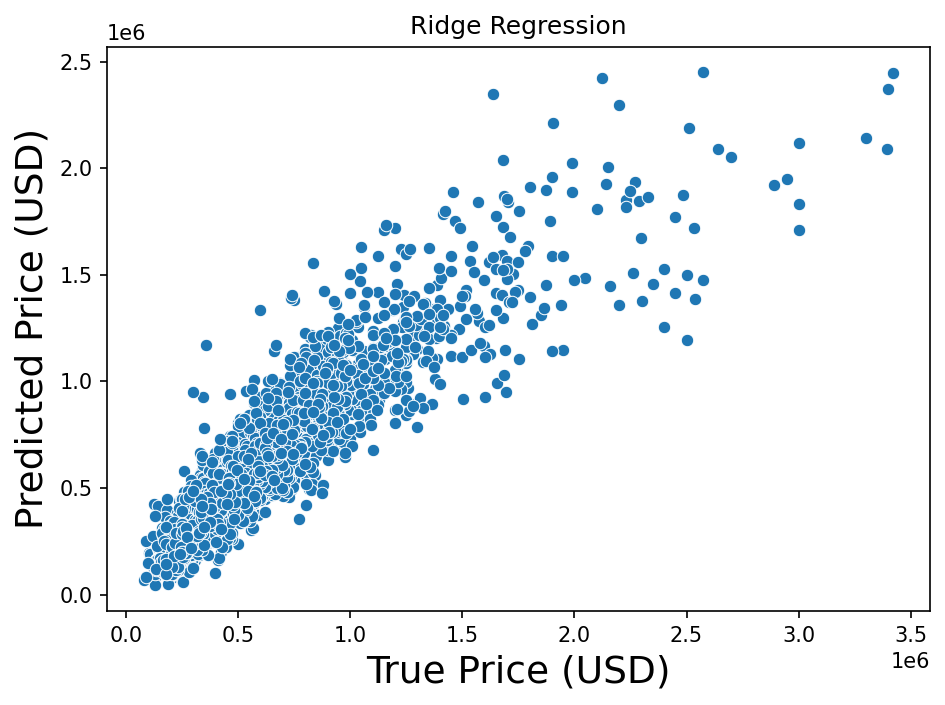

In [48]:
pred_true_plot = sns.scatterplot(x=test_y, y=pred_y)
pred_true_plot.set(xlabel="True Price (USD)", ylabel="Predicted Price (USD)", title="Ridge Regression");

### SGD Regressor - Take 2

In [49]:
model = SGDRegressor(loss="huber", epsilon=50000, max_iter=10000, random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
mse = mean_squared_error(test_y, pred_y)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_y, pred_y)
print(f"RMSE (USD): ${rmse:,.0f}, MAPE: {mape:.1%}")

RMSE (USD): $152,433, MAPE: 14.8%


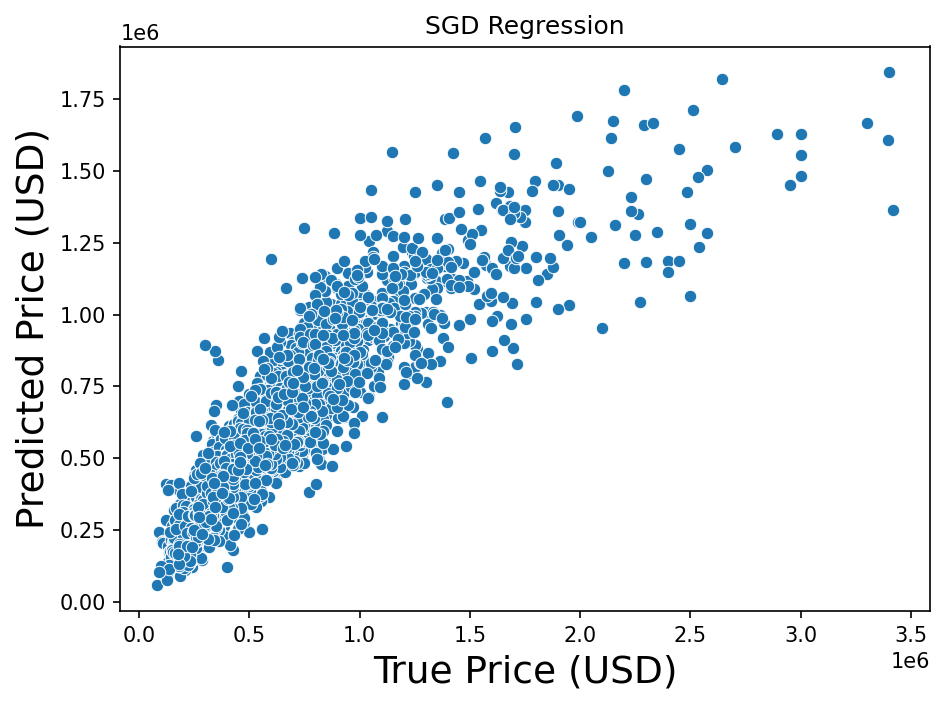

In [50]:
pred_true_plot = sns.scatterplot(x=test_y, y=pred_y)
pred_true_plot.set(xlabel="True Price (USD)", ylabel="Predicted Price (USD)", title="SGD Regression");

### Random Forest Regression - Take 2

In [51]:
model = RandomForestRegressor(max_depth=10, random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
mse = mean_squared_error(test_y, pred_y)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_y, pred_y)
print(f"RMSE (USD): ${rmse:,.0f}, MAPE: {mape:.1%}")

RMSE (USD): $121,240, MAPE: 14.0%


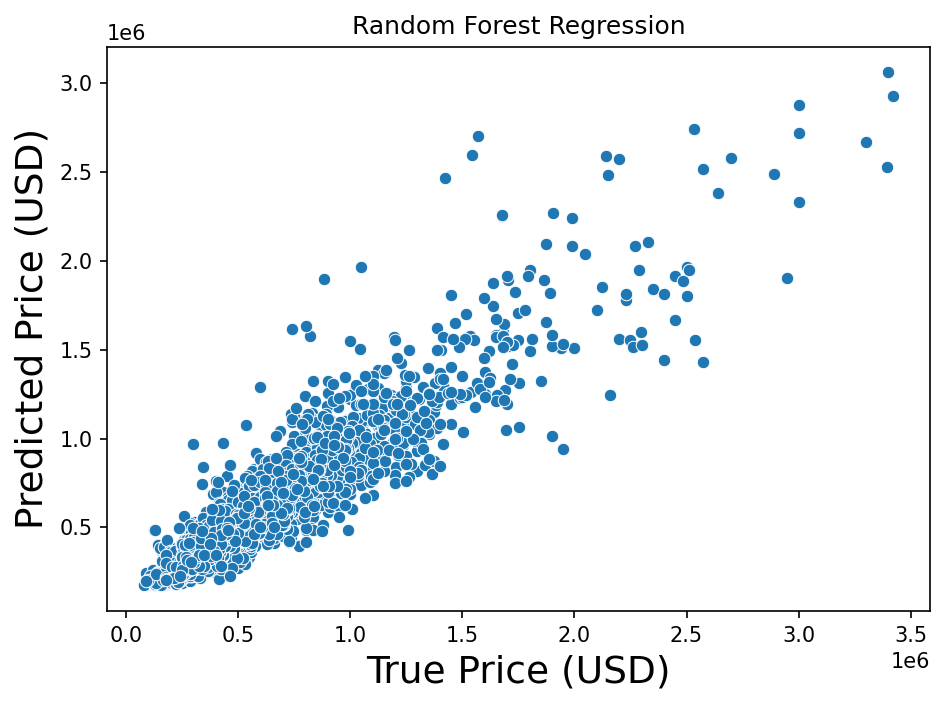

In [52]:
pred_true_plot = sns.scatterplot(x=test_y, y=pred_y)
pred_true_plot.set(xlabel="True Price (USD)", ylabel="Predicted Price (USD)", title="Random Forest Regression");